<a href="https://colab.research.google.com/github/chetan-parthiban/MSSP608/blob/master/Lectures/Day3_CrossValidation_Hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import calendar
import itertools
from scipy import stats
from matplotlib import dates
from datetime import datetime

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Prerequisite Knowledge 
In order to understand this notebook well you should already feel pretty comfortable with the following topics:
- Train/Test Splits
- Decision Trees
- Logistic Regression

Furthermore, in this notebook you will start to see some more advanced elements of python and code design. We will be using two elements of python called "lambda functions" and "list comprehension". Here are some references to better understand them
- [lambda functions](https://www.guru99.com/python-lambda-function.html)
- [list comprehension](https://www.pythonforbeginners.com/basics/list-comprehensions-in-python)

We'll also be writing our code primarily in highly general functions so that we can reuse our code to quickly run many different experiments.

# Downloading and Preprocessing the Data (Same as in Days 1/2)

If you understand this part of the Day 1 and Day 2 notebooks, then feel free to skip over reading this part of the notebook since it is exactly the same. 

In [2]:
# Download the data
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ' -O bikeshare_train.csv

--2020-01-24 00:52:37--  https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ
Resolving docs.google.com (docs.google.com)... 64.233.189.100, 64.233.189.102, 64.233.189.113, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7v1t2292k3lkdme0ladm9st24i8it4dk/1579824000000/09819396713149841370/*/0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ?e=download [following]
--2020-01-24 00:52:38--  https://doc-0s-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7v1t2292k3lkdme0ladm9st24i8it4dk/1579824000000/09819396713149841370/*/0B5qTk6DHjanhY2ZaOENiUnROQVZld1lQVXNVNzh0dnZodFdJ?e=download
Resolving doc-0s-5c-docs.googleusercontent.com (doc-0s-5c-docs.googleusercontent.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to d

In [3]:
bikeshare = pd.read_csv("bikeshare_train.csv")
bikeshare["date_objs"] = bikeshare["datetime"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
bikeshare["hour"] = bikeshare["date_objs"].apply(lambda x: x.hour)
bikeshare["day"] = bikeshare["date_objs"].apply(lambda x: x.day)
bikeshare["month"] = bikeshare["date_objs"].apply(lambda x: x.month)
bikeshare["year"] = bikeshare["date_objs"].apply(lambda x: x.year)
bikeshare["weekday"] = bikeshare["date_objs"].apply(lambda x: x.weekday())
bikeshare["plot_time"] = bikeshare["datetime"].apply(dates.datestr2num)

bikeshare["month_str"] = bikeshare["month"].apply(lambda x: calendar.month_name[x])
bikeshare["weekday_str"] = bikeshare["weekday"].apply(lambda x: calendar.day_name[x])
bikeshare["high_traffic"] = bikeshare["count"] > 145

def weather_norm(x):
    if x == 1:
        return "clear"
    if x == 2:
        return "overcast"
    if x > 2:
        return "gross"
    
bikeshare["weather_norm"] = bikeshare["weather"].apply(weather_norm)
print(bikeshare["weather_norm"].value_counts())
bikeshare.head()

clear       7192
overcast    2834
gross        860
Name: weather_norm, dtype: int64


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date_objs,hour,day,month,year,weekday,plot_time,month_str,weekday_str,high_traffic,weather_norm
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,0,1,1,2011,5,734138.000000,January,Saturday,False,clear
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,1,1,1,2011,5,734138.041667,January,Saturday,False,clear
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2,1,1,2011,5,734138.083333,January,Saturday,False,clear
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,3,1,1,2011,5,734138.125000,January,Saturday,False,clear
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,4,1,1,2011,5,734138.166667,January,Saturday,False,clear


# Cross-Validation

Here we'll move from having a single train-test split to training our model on several different train-test splits. This technique, called cross-validation, allows us to perform statistical analysis on the differing results between different models and it also allows us to fully utilize our data, which is especially important when our dataset is smaller in size! 

![](https://miro.medium.com/max/720/1*chD302ssE0O62wreunGp4A.jpeg)

Let's start this notebook by seeing how we can easily use cross validation using scikit-learn's build in tools. 

In [0]:
# Define a function that takes in the predictions of a classifier, the true labels,
# and a set of metrics and displays the model's performance on the metrics. This is
# very similar to the function we used in the Day 2 notebook!

def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Metrics
    conf_matrix = confusion_matrix(y_actual, y_pred)
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

Decision Tree: Fold 0 Results


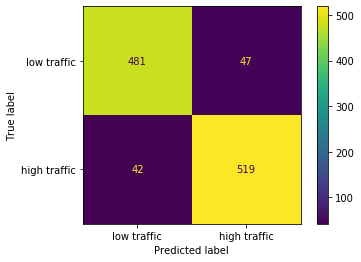

{'Accuracy': 91.82736455463728, 'Kappa': 0.8363514793558813, 'Precision': 0.9169611307420494, 'Recall': 0.9251336898395722}
------------------------
Decision Tree: Fold 1 Results


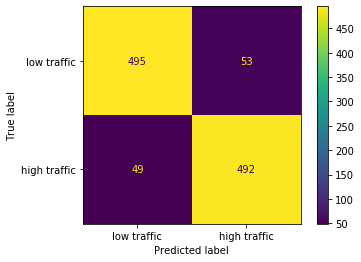

{'Accuracy': 90.633608815427, 'Kappa': 0.8126732820204936, 'Precision': 0.9027522935779817, 'Recall': 0.9094269870609981}
------------------------
Decision Tree: Fold 2 Results


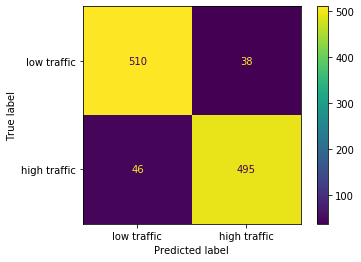

{'Accuracy': 92.28650137741047, 'Kappa': 0.8457090810956687, 'Precision': 0.9287054409005628, 'Recall': 0.9149722735674677}
------------------------
Decision Tree: Fold 3 Results


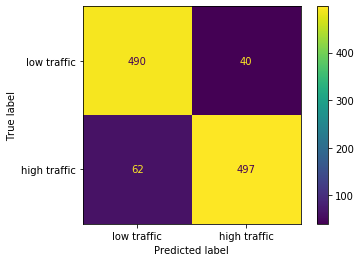

{'Accuracy': 90.633608815427, 'Kappa': 0.812740863619352, 'Precision': 0.925512104283054, 'Recall': 0.889087656529517}
------------------------
Decision Tree: Fold 4 Results


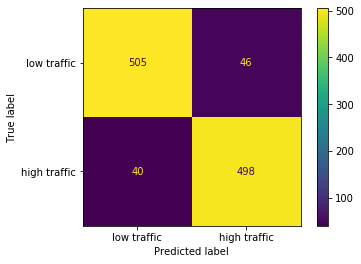

{'Accuracy': 92.1028466483012, 'Kappa': 0.842055201583934, 'Precision': 0.9154411764705882, 'Recall': 0.9256505576208178}
------------------------
Decision Tree: Fold 5 Results


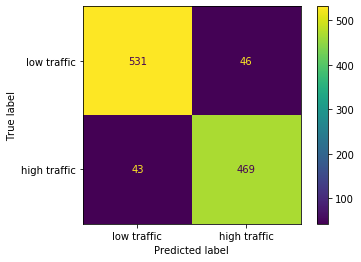

{'Accuracy': 91.82736455463728, 'Kappa': 0.8360170072228248, 'Precision': 0.9106796116504854, 'Recall': 0.916015625}
------------------------
Decision Tree: Fold 6 Results


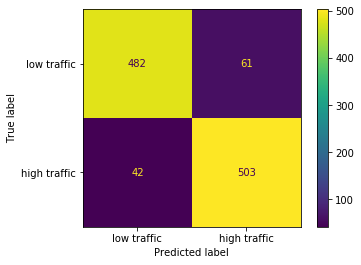

{'Accuracy': 90.53308823529412, 'Kappa': 0.8106489679503643, 'Precision': 0.8918439716312057, 'Recall': 0.9229357798165138}
------------------------
Decision Tree: Fold 7 Results


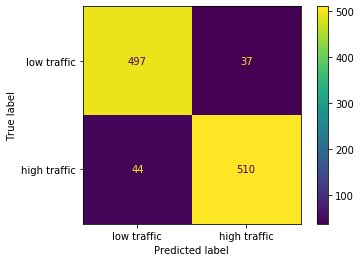

{'Accuracy': 92.55514705882352, 'Kappa': 0.851087845464438, 'Precision': 0.9323583180987203, 'Recall': 0.9205776173285198}
------------------------
Decision Tree: Fold 8 Results


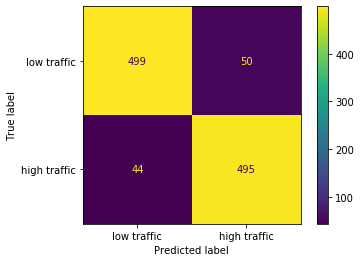

{'Accuracy': 91.36029411764706, 'Kappa': 0.8272088017544037, 'Precision': 0.908256880733945, 'Recall': 0.9183673469387755}
------------------------
Decision Tree: Fold 9 Results


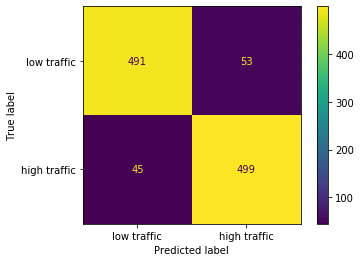

{'Accuracy': 90.99264705882352, 'Kappa': 0.8198529411764706, 'Precision': 0.9039855072463768, 'Recall': 0.9172794117647058}
------------------------
Mean Decision Tree Accuracy: 91.47524712364284
------------------------
Logistic Regression: Fold 0 Results


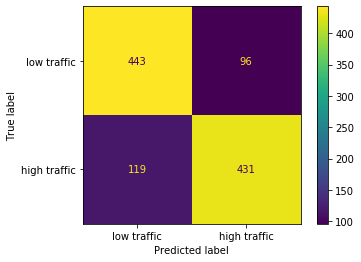

{'Accuracy': 80.25711662075298, 'Kappa': 0.6052704782745767, 'Precision': 0.8178368121442126, 'Recall': 0.7836363636363637}
------------------------
Logistic Regression: Fold 1 Results


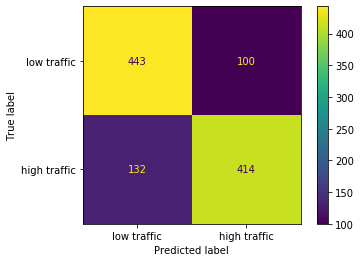

{'Accuracy': 78.69605142332415, 'Kappa': 0.57398676675907, 'Precision': 0.8054474708171206, 'Recall': 0.7582417582417582}
------------------------
Logistic Regression: Fold 2 Results


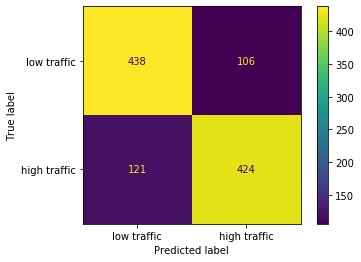

{'Accuracy': 79.15518824609734, 'Kappa': 0.5831139592731566, 'Precision': 0.8, 'Recall': 0.7779816513761468}
------------------------
Logistic Regression: Fold 3 Results


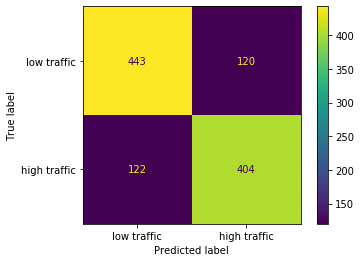

{'Accuracy': 77.77777777777779, 'Kappa': 0.5549863053485128, 'Precision': 0.7709923664122137, 'Recall': 0.7680608365019012}
------------------------
Logistic Regression: Fold 4 Results


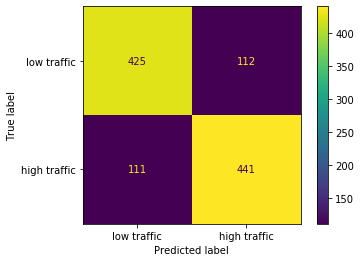

{'Accuracy': 79.52249770431588, 'Kappa': 0.5903618725678226, 'Precision': 0.7974683544303798, 'Recall': 0.7989130434782609}
------------------------
Logistic Regression: Fold 5 Results


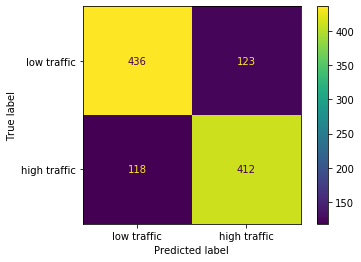

{'Accuracy': 77.8696051423324, 'Kappa': 0.5571863637514025, 'Precision': 0.7700934579439253, 'Recall': 0.7773584905660378}
------------------------
Logistic Regression: Fold 6 Results


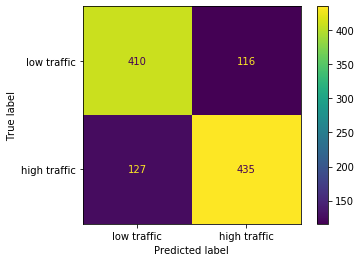

{'Accuracy': 77.66544117647058, 'Kappa': 0.5531185558297556, 'Precision': 0.7894736842105263, 'Recall': 0.7740213523131673}
------------------------
Logistic Regression: Fold 7 Results


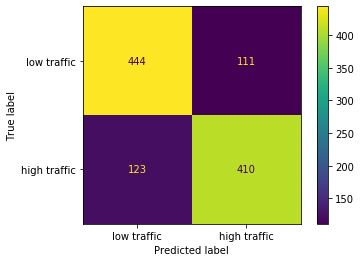

{'Accuracy': 78.49264705882352, 'Kappa': 0.5694848875315794, 'Precision': 0.7869481765834933, 'Recall': 0.7692307692307693}
------------------------
Logistic Regression: Fold 8 Results


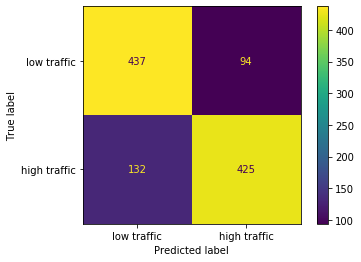

{'Accuracy': 79.22794117647058, 'Kappa': 0.585014564860039, 'Precision': 0.8188824662813102, 'Recall': 0.7630161579892281}
------------------------
Logistic Regression: Fold 9 Results


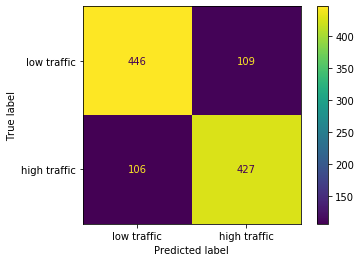

{'Accuracy': 80.23897058823529, 'Kappa': 0.6046618533841703, 'Precision': 0.7966417910447762, 'Recall': 0.801125703564728}
------------------------
Mean Logistic Regression Accuracy: 78.89032369146005
------------------------
Best classifier is: Decision Tree 
With: 91.5% accuracy.


In [5]:
# Pick Classifiers to Compare
classifiers = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=123),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", multi_class='ovr', max_iter=10000, random_state=123),
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score,
    "Precision": precision_score,
    "Recall"   : recall_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick Features to Use
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Set up our dataset and cross validation split
X = bikeshare.loc[:, feature_set]
X = pd.get_dummies(X)
y = bikeshare["high_traffic"]
kf = KFold(n_splits=10, shuffle=True)

# Initialize variables to store results
best = 0
best_name = None

classifier_comparison = {}

# Compute and compare metrics for all classifiers
for classifier_name, classifier in classifiers.items():

    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate Model
        model = classifier.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

        # Display Results
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, ["low traffic", "high traffic"]).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")
    
    # Compute the average result for the metric we are optimizing over
    optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])
    
    # Update our tracking variables
    classifier_comparison[classifier_name] = all_fold_metrics
    
    if optimization_metric_avg > best:
        best = optimization_metric_avg
        best_name = classifier_name
    
    # Display Results
    print(f"Mean {classifier_name} {metric_to_optimize}: {optimization_metric_avg}")
    print("------------------------")

# Display our final result
print(f"Best classifier is: {best_name} \nWith: {best:.1f}% accuracy.")    

## Rewriting Our Comparisons as a Function
We can also move this whole functionality into a function so we can call it in the future, moving the exact number of folds to a parameter in the function call.

In [0]:
"""
Options for noisy: "loud", "quiet", and other. Any other value prints nothing (silent).
"""

# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Then define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud'):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, ["low traffic", "high traffic"]).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Then define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud'):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

#Dont worry about these two lines
@ignore_warnings(category=ConvergenceWarning)
@ignore_warnings(category=UndefinedMetricWarning)
# Then define a function to compare different classifiers
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud'):
    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = KFold(n_splits=folds, shuffle=shuffle)

    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': 
            print()
            print(f"Average {metric_to_optimize}: {optimization_metric_avg}")
            print('-------------')
    # Return our results
    return best, best_name, classifier_comparison
    

In [7]:
# Pick Classifiers to Compare
classifiers = {
    "Decision Tree": DecisionTreeClassifier(criterion="entropy", random_state=123),
    "Logistic Regression": LogisticRegression(penalty="none", solver="lbfgs", multi_class='ovr', max_iter=10000, random_state=123),
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score,
    "Precision": precision_score,
    "Recall"   : recall_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick features to use
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bikeshare, feature_set, "high_traffic", noisy = 'quiet')

print(f"Best classifier is: {best_name} \nWith: {best:.1f}% accuracy.")    

Decision Tree: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.35604879003944
-------------
Logistic Regression: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 78.9364230540701
-------------
Best classifier is: Decision Tree 
With: 91.4% accuracy.


## Plotting variation in performance, by fold

We can use visualization to see just how much of our performance is likely coming from random variation in which instances landed in our test set, instead of real variation in the accuracy of the classifier.

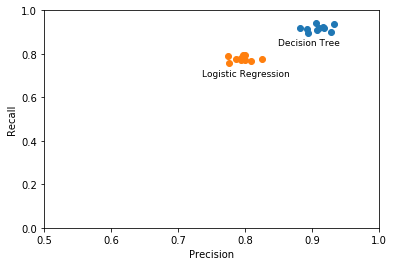

In [8]:
# Set Up Plotting
plt.xlim(0.5,1)
plt.xlabel("Precision")
plt.ylim(0,1)
plt.ylabel("Recall")

# Plot Data
for classifier in classifier_comparison:
    x = classifier_comparison[classifier]["Precision"]
    y = classifier_comparison[classifier]["Recall"]
    plt.scatter(x, y)
    plt.text(np.mean(x)-.06, np.mean(y)-.08, classifier, fontsize=9)

## Statistical significance of differences in cross-validation

Testing differences between models gets a lot easier than working with once we have multiple estimates! Now we have genuine paired comparisons and we can run a simple t-test on the resulting data from each fold.

In [9]:
metric_to_compare = "Accuracy"
trees_results = classifier_comparison["Decision Tree"][metric_to_compare]
regression_results = classifier_comparison["Logistic Regression"][metric_to_compare]

trees_mean = np.mean(trees_results)
regression_mean = np.mean(regression_results)
t, p = stats.ttest_rel(trees_results, regression_results)

print(f"Is {trees_mean:.3f} statistically different than {regression_mean:.3f}?")
if p < 0.01:
    print("Yes", end=', ')
else:
    print("No", end=', ')
print(f"t={t:.3f}, p={p:.4f}")


Is 91.356 statistically different than 78.936?
Yes, t=28.902, p=0.0000


## The impact of small data

So far we've been working on a single dataset at a time, mostly fixed in place. By introducing cross-validation we show that different, equally-sized sets of similar data can produce different results. But often in a real-world context we'll find that _gathering_ the data in the first place is part of our job (we'll cover this more in weekend 2). 

One thing we might want to know is just how fast our learning rate is improving as we add more and more data. Crucially, we're also going to have to answer a key question: How much data do we need?

In [0]:
def evaluate_overfitting(df, min_split, noisy=True):
    
    # Prep Data
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df["high_traffic"]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

    # Train Model
    model = DecisionTreeClassifier(criterion="entropy", min_samples_split=min_split, random_state=123).fit(X_train, y_train)

    # Evaluate on Train Set
    overfit_pred = model.predict(X_train)
    overfit_accuracy = 100*accuracy_score(y_train, overfit_pred)

    # Evaluate on Test Set
    y_pred = model.predict(X_test)
    accuracy = 100*accuracy_score(y_test, y_pred)
    tree_size = model.get_n_leaves()

    # Print outputs if necessary
    if noisy:
        print(f"   Training Accuracy: {overfit_accuracy:.1f}%")
        print(f"   Testing Accuracy: {accuracy:.1f}%")
        print(f"   Tree contains {tree_size} leaves")
        print('-----------------')

    return tree_size, accuracy, overfit_accuracy

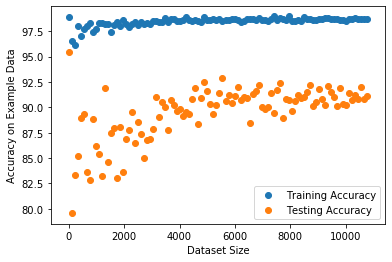

In [11]:
accuracies = []
overfit_accuracies = []

# For different Sized Data sets
for i in range(100):
    bikeshare_small = bikeshare.iloc[bikeshare.index % 100 <= i]
    # Evaluate and store how much the tree overfits
    tree_size, accuracy, overfit_accuracy = evaluate_overfitting(bikeshare_small, 5, noisy=False)
    accuracies.append(accuracy)
    overfit_accuracies.append(overfit_accuracy)

# Plot the Results
ax = plt.gca()
x_index = [x * (len(bikeshare)/100) for x in range(100)]
ax.scatter(x_index, overfit_accuracies)
ax.scatter(x_index, accuracies)
plt.ylabelbest = 0
plt.ylabel("Accuracy on Example Data")
plt.xlabel("Dataset Size")
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

# Hyperparameter Optimization

If you look through the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for any of the scikit-learn models, you'll quickly notice that there are a TON of potential inputs you can give to the model. These are the "hyperparameters" of the model. Whereas the model parameters are the things learned by the model during training, you can think of the hyperparameters as the "settings" of the model that you decide on BEFORE training. These are important, because there are many different ways that we can perform the same tasks and, instead of having a different model type for each of these different subtle variants, it makes more sense to have one base model with different settings for these variants. 

While having this flexibility is useful, it also means that we have a lot of decisions to make every time we train a model as a data scientist. The more often we have to make decisions, the more often there is potential for us do to something incorrectly. Therefore, it makes sense that we may want to come up with a procedure to pick the best hyperparameters for our model type and data. We call this process hyperparameter optimization, and we will spend the rest of the note book exploring it.  

- [Awesome resource on hyperparameter optimization with great visuals](https://www.jeremyjordan.me/hyperparameter-tuning/)
- [Common problems with hyperparameter optimization](https://sigopt.com/blog/common-problems-in-hyperparameter-optimization)

DANGER: When you perform hyperparameter optimization, make sure you use a Train/Validation/Test Split! If you optimize your hyperparameter on test set performance, this results in you inadvertently feeding information about the test set to your model during the hyperparameter optimization process. This will result in you overfitting to the test set and you will likely see a drop in performance when you try to deploy your model on new data!




## Decision Tree Hyperparameters

Lets start our exploration of hyperparameters with decision trees. Some of the parameters that we often tune in decision trees are the criteria used to measure leaf purity, the size of our tree, and the definition of what constitutes a "pure" leaf. [However, there are many other interesting parameters as well.](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680) While we may not have time to explore many of them in class, I would definitely recommended you to explore them as they will provide you with even more tools in your data science tool kit for tackling new problems. 

In [0]:
# Parameters to tune:
# - Measurement of leaf purity (gini vs. information gain)
# - Size of splits (tree size)
# - Definition of purity

criteria = ["gini", "entropy"]

size_of_splits = range(2, 150, 2)

purity = [0, 0.0001, 0.001, 0.01, 0.1]

### Tuning the Minimum Split Size 
One hyperparameter to tune, based on the quantity of data available and the homogeneity of your domain, is the complexity of the trees that you want to learn. Here we'll show how a more and more complex tree doesn't necessarily result in generalization to new data that we've never seen before, even as performance on the training set improves! We call this phenomenon of growing disparity between train and test set results "overfitting". 

We'll start by tuning the minimum split size. This parameter adds a constraint that only allows the tree to split a node if there are at least N samples involved in the split. This prevents us ending up with a bunch of extra nodes and a different leaf for every datapoint -- which often means our model is overfitted. Basically, increasing this parameter helps us go from the tree on the right to the one on the left:
![](https://alanjeffares.files.wordpress.com/2018/07/overfitting-001.png?w=996)

In [0]:
def evaluate_overfitting(df, min_split, noisy=True):
    
    # Prep Data
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df["high_traffic"]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

    # Train Model
    model = DecisionTreeClassifier(criterion="entropy", min_samples_split=min_split, random_state=123).fit(X_train, y_train)

    # Evaluate on Train Set
    overfit_pred = model.predict(X_train)
    overfit_accuracy = 100*accuracy_score(y_train, overfit_pred)

    # Evaluate on Test Set
    y_pred = model.predict(X_test)
    accuracy = 100*accuracy_score(y_test, y_pred)
    tree_size = model.get_n_leaves()

    # Print outputs if necessary
    if noisy:
        print(f"   Training Accuracy: {overfit_accuracy:.1f}%")
        print(f"   Testing Accuracy: {accuracy:.1f}%")
        print(f"   Tree contains {tree_size} leaves")
        print('-----------------')

    return tree_size, accuracy, overfit_accuracy

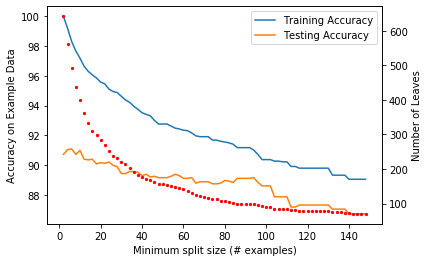

The best minimum split size is 6 with a tree size of 492 and accuracy of 91.09274563820018


In [14]:
size_of_splits = range(2, 150, 2)

# Initialize Storage Variables
leaves = []
accuracies = []
overfit_accuracies = []

best = 0
best_size = None
best_name = []

# For each split size
for i in size_of_splits:

    # Compute the tree_size, train, and test accuracy for the tree
    tree_size, accuracy, overfit_accuracy = evaluate_overfitting(bikeshare, i, noisy=False)

    # Update our tracking variables
    leaves.append(tree_size)
    accuracies.append(accuracy)
    overfit_accuracies.append(overfit_accuracy)

    if accuracy > best:
        best = accuracy
        best_size = tree_size
        best_name = i

# Plot the effect of tree size on Accuracy    
ax = plt.gca()
ax.plot(size_of_splits, overfit_accuracies)
ax.plot(size_of_splits, accuracies)

plt.ylabel("Accuracy on Example Data")
plt.xlabel("Minimum split size (# examples)")
plt.legend(["Training Accuracy", "Testing Accuracy"])

right_ax = ax.twinx()
right_ax.scatter(size_of_splits, leaves, s=5, color="red")
plt.ylabel("Number of Leaves")
plt.show()

# Print the info on the best classifier
print(f'The best minimum split size is {best_name} with a tree size of {best_size} and accuracy of {best}')

We see, then, that our most fine-grained model with 2-instance splits allowed gets us a model with over 600 leaves and 90% accuracy on testing data, but if we limit our tree drastically (for instance, to minimum split size between 50-100 instances), we see a reduction in accuracy as small as 1% while the model complexity drops down to only 100 leaves. 

In many cases, you may find that performance on the test set actually increases when model complexity goes down! Further, these smaller models are much easier to understand and interpret, which can be very valuable in safety-critical applications. 

We can also notice that this training loop is very similar to what we were doing when we were comparing different models. This is because, we are essentially comparing many different models -- they just happen to all be trees. Let's try to compare these different hyperparameters in the workflow we used before. 

### Tuning purity threshold

The purity threshold is another method we can use to limit the size of the tree. Basically it says "only create a split if the split makes the new leaves at least this much more pure". Remember impurity is a measure of how homogenous any particular leaf of our tree is. Look at the following visual to see what we mean by a better or "purer" split and a worse or "more impure" split:
![](https://dimensionless.in/wp-content/uploads/RandomForest_blog_files/figure-html/gini.png)

Decision Tree with Purity Threshold = 0: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.40183587208988
-------------
Decision Tree with Purity Threshold = 0.0001: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.53048702263274
-------------
Decision Tree with Purity Threshold = 0.001: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 90.16159252957382
-------------
Decision Tree with Purity Threshold = 0.01: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 85.83465841570788
-------------
Decision Tree with Purity Threshold = 0.1: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.2643969777994
-------------
Best classifier is: Decision Tree with Purity Threshold = 0.0001 
With: 91.5% accuracy.


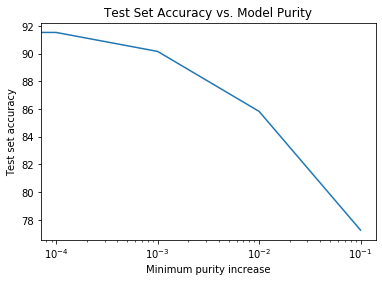

In [15]:
# Pick Classifiers to Compare
classifiers = {
    f'Decision Tree with Purity Threshold = {pur}': DecisionTreeClassifier(criterion="entropy", min_impurity_decrease=pur, random_state=123)
    for pur in purity
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick features to use
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bikeshare, feature_set, "high_traffic", noisy = 'quiet')

print(f"Best classifier is: {best_name} \nWith: {best:.1f}% accuracy.") 

# Compute the average accuracy for each model
accuracies = [np.mean(classifier_comparison[classifier]['Accuracy']) for classifier in classifier_comparison]

# Plot the relation between purity and accuracy
plt.title('Test Set Accuracy vs. Model Purity')
plt.plot(purity, accuracies)
plt.xlabel("Minimum purity increase")
plt.xscale("log")
plt.ylabel("Test set accuracy")
plt.show()

Here we can see that increasing the purity threshold past 0.0001 significantly hurts our model's performance. 

### Tuning purity criterion

There are several ways we can compute how "pure" a given leaf node is. Let's see if adjust this hyperparameter has any large effects on our model. If you feel like it, [you can read more on how gini and entropy are different here.](https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb)

In [16]:
# Pick Classifiers to Compare
classifiers = {
    f'Decision Tree with Purity Criterion = {crit}': DecisionTreeClassifier(criterion=crit, random_state=123)
    for crit in criteria
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick features to use
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bikeshare, feature_set, "high_traffic", noisy = 'quiet')

print(f"Best classifier is: {best_name} \nWith: {best:.1f}% accuracy.") 

# Compute the average accuracy for each model
accuracies = [np.mean(classifier_comparison[classifier]['Accuracy']) for classifier in classifier_comparison]

Decision Tree with Purity Criterion = gini: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 90.78646592934695
-------------
Decision Tree with Purity Criterion = entropy: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.25489520877221
-------------
Best classifier is: Decision Tree with Purity Criterion = entropy 
With: 91.3% accuracy.


Here we can see that, in this case, purity criterion does not have a large affect on our resulting output. 

### Combining hyperparameters for tuning

We can also optimize over two (or more) different hyperparameters at the same time. In this example, we perform a type of search called "Exhaustive Grid Search". In Exhaustive Grid Search, we create a list of options for each hyperparameter. Then we create a "grid" of all possible combinations of the hyperparameters and test every element of the grid. This search is called "exhaustive" because we check every possible. In general, this can be a very expensive operation, because the number of grid points grows exponentially with the number of hyperparameters! [There are many clever alternatives that have been developed to make hyperparameter optimization more practical.](https://medium.com/criteo-labs/hyper-parameter-optimization-algorithms-2fe447525903) This is what gridsearch would look like if we were optimizing for z based on x and y -- notice how we are systematically checking each point in the grid of possibilities:

![](https://thumbs.gfycat.com/ScholarlyAnxiousAdeliepenguin-size_restricted.gif)

In [17]:
# This code creates a list containing every different combination of criterion and split_size
hyperparameters = itertools.product(criteria, size_of_splits)

# Pick Classifiers to Compare
classifiers = {
    f'Decision Tree with Purity Criterion = {crit}, split_size = {size}': DecisionTreeClassifier(criterion=crit, min_samples_split = size, random_state=123)
    for crit,size in hyperparameters
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick features to use
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bikeshare, feature_set, "high_traffic", noisy = 'quiet')

print(f"Best classifier is: {best_name} \nWith: {best:.1f}% accuracy.") 

# Compute the average accuracy for each model
accuracies = [np.mean(classifier_comparison[classifier]['Accuracy']) for classifier in classifier_comparison]

Decision Tree with Purity Criterion = gini, split_size = 2: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.14460109112517
-------------
Decision Tree with Purity Criterion = gini, split_size = 4: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 90.92432513639065
-------------
Decision Tree with Purity Criterion = gini, split_size = 6: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.04339686976718
-------------
Decision Tree with Purity Criterion = gini, split_size = 8: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.29144047426132
-------------
Decision Tree with Purity Criterion = gini, split_size = 10: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.08031349592179
-------------
Decision Tree with Purity Criterion = gini, split_size = 12: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 91.41108612866634
-------------
Decision Tree with Purity Criterion = gini, split_size = 14: Fold 0...1...2...3.

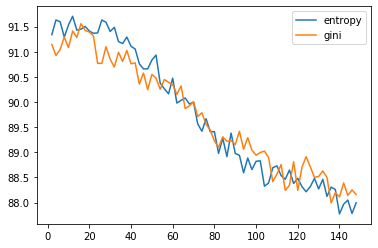

In [18]:
entropys = []
ginis = []

# Separate classifiers using entropy from classifiers using gini
entropys = [np.mean(classifier_comparison[classifier]['Accuracy']) for classifier in classifier_comparison if 'entropy' in classifier]
ginis = [np.mean(classifier_comparison[classifier]['Accuracy']) for classifier in classifier_comparison if 'gini' in classifier]

# Plot both as a function of the minimum split size
plt.plot(size_of_splits, entropys)
plt.plot(size_of_splits, ginis)

plt.legend(['entropy', 'gini'])
plt.show()

So on this dataset, it looks like we don't have a *lot* of tuning we can do with decision trees - the entropy criterion we started with is slightly better in performance compared to the gini criterion, and reducing the number of splits only starts hurting accuracy once you've really shrunk the tree. Interestingly, on this dataset the enropy criterion worsens faster than gini as the tree size gets smaller, so for smaller trees the difference between the two appears to be minimal. 

## Tuning Logistic Regression

Now lets see if we can apply these same hyperparameter ideas to logistic regression by exploring different amounts/types of regularization. Remember, regularization in logistic regression acts very similarly to restricting tree complexity -- it is a way we can try to avoid overfitting in our models. Two commonly used methods are L1 and L2 Regression, which involve adding a penalty term to the cost function that penalizes the model for having large parameter values: 

$$Unregularized \space Regression \space Cost = \sum_{y_i \in Y} y_ilog(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i)$$

$$L1 \space Regularized \space Regression \space Cost = \sum_{y_i \in Y} y_ilog(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i) + \lambda \sum_j^p||\beta_j||$$

$$L2 \space Regularized \space Regression \space Cost = \sum_{y_i \in Y} y_ilog(\hat{y}_i) + (1-y_i)log(1-\hat{y}_i) + \lambda \sum_j^p \beta_j^2$$

We call the parameter $\lambda$ the "strength" of the regularization as it controls the weight between the regularization term and the normal cross entropy term that we optimize in logistic regression. There is also a third commonly used type of regularization called "elasticnet" which is basically just a combination of L1 and L2 regularization. It has an additional hyperparameter that controls the ratio of L1 to L2 regularization used by the model. When training our model with any of these regularized costs, we still use gradient descent as usual, but we just use it with this new cost function. 

In [0]:
# Here are some hyperparameters we could potentially optimize over

# Types of Regularization
cost_type = ["l1", "l2", "elasticnet", "none"]

# Types of elasticnet mix ratio
elastic_net_mixes = np.arange(0,1,0.1)

# Strength of regularization
strengths = [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000]

### Tuning regularization strength

Let's see how much regularization is enough (and how much is too much)!


Logistic Regression with C = 0.0001: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 74.1227701480041
-------------
Logistic Regression with C = 0.001: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 76.40995516663966
-------------
Logistic Regression with C = 0.01: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.23664620807
-------------
Logistic Regression with C = 0.1: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.42980439420947
-------------
Logistic Regression with C = 1: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.54929812834224
-------------
Logistic Regression with C = 10: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.48455477232216
-------------
Logistic Regression with C = 1000: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.5766944174364
-------------
Best classifier is: Logistic Regression with C = 1000 
With: 77.6% accuracy.


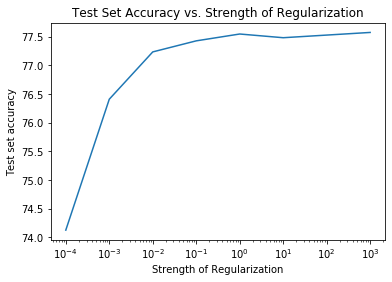

In [20]:
# Pick Classifiers to Compare
classifiers = {
    f'Logistic Regression with C = {strength}': LogisticRegression(penalty="l1", C=strength, solver="saga", max_iter=1000, random_state=123)
    for strength in strengths
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick features to use
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bikeshare, feature_set, "high_traffic", noisy = 'quiet')

print(f"Best classifier is: {best_name} \nWith: {best:.1f}% accuracy.") 

# Compute the average accuracy for each model
accuracies = [np.mean(classifier_comparison[classifier]['Accuracy']) for classifier in classifier_comparison]

# Plot the relation between regularization strength and accuracy
plt.title('Test Set Accuracy vs. Strength of Regularization')
plt.plot(strengths, accuracies)
plt.xlabel("Strength of Regularization")
plt.xscale("log")
plt.ylabel("Test set accuracy")
plt.show()

We can see that adding some regularization definitely helps our model performance on the test set! But also, notice that, after some point, regularization begins to have some slight negative effects on our accuracy. If you push it even further, eventually the penalty will be too strong for your model to learn and it will break your model. 

### Tuning ElasticNet Ratio
Lets also try using elasticnet regularization and tune the ratio between L1 and L2 regularization!

Logistic Regression with elasticnet ratio = 0.0: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.58575055366498
-------------
Logistic Regression with elasticnet ratio = 0.1: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.65958380597418
-------------
Logistic Regression with elasticnet ratio = 0.2: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.57657625722466
-------------
Logistic Regression with elasticnet ratio = 0.30000000000000004: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.52174147896072
-------------
Logistic Regression with elasticnet ratio = 0.4: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.55820234429859
-------------
Logistic Regression with elasticnet ratio = 0.5: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.54902804785827
-------------
Logistic Regression with elasticnet ratio = 0.6000000000000001: Fold 0...1...2...3...4...5...6...7...8...9
Average Accuracy: 77.5127

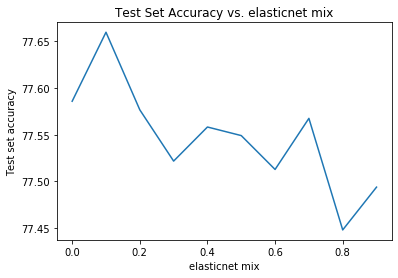

In [21]:
# Pick Classifiers to Compare
classifiers = {
    f'Logistic Regression with elasticnet ratio = {mix}': LogisticRegression(penalty="elasticnet", C=1, l1_ratio=mix, solver="saga", max_iter=1000, random_state=123)
    for mix in elastic_net_mixes
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Accuracy'

# Pick features to use
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bikeshare, feature_set, "high_traffic", noisy = 'quiet')

print(f"Best classifier is: {best_name} \nWith: {best:.1f}% accuracy.") 

# Compute the average accuracy for each model
accuracies = [np.mean(classifier_comparison[classifier]['Accuracy']) for classifier in classifier_comparison]

# Plot the relation between regularization strength and accuracy
plt.title('Test Set Accuracy vs. elasticnet mix')
plt.plot(elastic_net_mixes, accuracies)
plt.xlabel("elasticnet mix")
plt.ylabel("Test set accuracy")
plt.show()

From this, we can see that the elasticnet mix doesn't seem to have a big effect on the fit for this dataset.

### Changing the prediction threshold

Right now we are just saying that if our model outputs more than 0.5 that counts as a prediction for "1" and less than 0.5 counts for a prediction for "0". While this value of 0.5 is commonly used because it treats each class equally, it is actually itself a hyperparameter that we can tune for our own uses. Unfortunately, optimizing this hyperparameter doesn't fit in the framework we built before so we will have to write the code from scratch again. 

In [0]:
# Pick features to use
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Prep the data
X = bikeshare.loc[:, feature_set]
X = pd.get_dummies(X)
y = bikeshare["high_traffic"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

# Initialize and Train our model
model = LogisticRegression(penalty="elasticnet", C=1, l1_ratio=0.5, solver="saga", max_iter=5000, random_state=123)
model.fit(X_train, y_train)

# Get our predictions on the test set
predicts = model.predict_proba(X_test)
all_probabilities = [x[1] for x in predicts]
all_actuals = list(y_test)

# Initialize storage variables
true_positive_rates = []
false_positive_rates = []
precisions = []
recalls = []

# For several different thresholds
for threshold in np.arange(0, 0.99, 0.01):
    # Compute/store precision and recall
    all_predictions = [x > threshold for x in all_probabilities]
    precision = precision_score(all_predictions, all_actuals, pos_label=True)
    recall = recall_score(all_predictions, all_actuals, pos_label=True, zero_division=1) 
    precisions.append(precision)
    recalls.append(recall)

    # Compute/store true/false positives
    count_positives = np.sum([int(all_actuals[i] == True) for i in range(len(all_actuals))])
    count_negatives = np.sum([int(all_actuals[i] == False) for i in range(len(all_actuals))])
    
    true_positive = np.sum([all_predictions[i] == True and all_actuals[i] == True for i in range(len(all_predictions))])
    false_positive = np.sum([all_predictions[i] == True and all_actuals[i] == False for i in range(len(all_predictions))])

    true_positive_rates.append(true_positive / count_positives)
    false_positive_rates.append(false_positive / count_negatives)


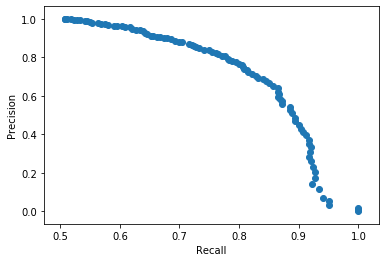

In [23]:
# Lets examine the relationship between recall and precision
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.scatter(recalls, precisions)
plt.show()

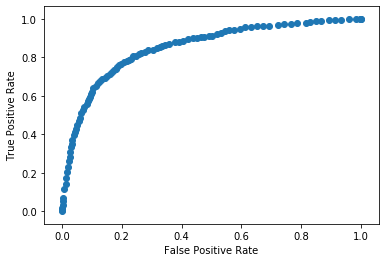

In [24]:
# Lets examine the relationship between true and false positives
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.scatter(false_positive_rates, true_positive_rates)
plt.show()

With these charts, we see that a single logistic regression actually gives us a fairly wide, flexible range of classifiers: 
   - We can build a model that has 20% false positives but correctly identifies around 80% of true positive cases.
   - Or we can build a model that successfully finds about 90% of true positives while filtering out about 50% of false cases.

By default the model will find a balance between the two metrics. But there might be value in this tuning for your application!

## Hyperparameter tuning with Scikit-learn

One of the key advantages of working in Python is that much of the unwieldy work we've been doing this weekend is either built into the language by the default, or is available in the form of libraries. If all you're looking for is to train an optimal classifier with simple code, Scikit-learn has given us tools to get a lot done with built-in library tools. 

Here's a sample that sets aside a test set, does hyperparameter tuning within our training set using cross-validation, model quality reporting, and final training of the full training set using our best parameters all in one place.

In [25]:
# Decide on our features from the data
date_features = ["day", "month_str", "year", "weekday_str", "season", "holiday", "workingday"]
time_features = ["hour"]
weather_features = ["weather", "temp", "atemp", "humidity", "windspeed"]

feature_set = date_features + time_features + weather_features

# Prepare our dataset
X = bikeshare.loc[:, feature_set]
X = pd.get_dummies(X)
y = bikeshare["high_traffic"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123, shuffle=True)

# Decide on the hyperparameters we would like to compare
hyperparameters = {
    "criterion":["gini", "entropy"],
    "min_impurity_decrease":[0, 0.0001, 0.001],
    "min_samples_split":range(2, 20, 2)
}

# Decide on our number of folds for cross validation in the hyerparameter search
kfolds = 5

# Initialize a search using cross validation in sklearn
search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                            param_grid=hyperparameters, cv=kfolds, scoring="accuracy")

# Train a classifier with each combination of hyperparameters and take the best one
# and print out the results
classifier = search.fit(X_train, y_train)
accuracy = classifier.best_score_
best_fit = classifier.best_estimator_
print(f"Best fit when training was {best_fit}\nWith {100*accuracy:.1f}% accuracy.")

# Evaluate our best model's performance on the test set and print the results
y_pred = classifier.predict(X_test)
accuracy = 100*accuracy_score(y_test, y_pred)
print(f"Accuracy on held-out test set: {accuracy:.1f}%")

Best fit when training was DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
With 91.3% accuracy.
Accuracy on held-out test set: 90.9%


Here is some more information on GridSearchCV in scikit-learn as well as some other types of search algorithms implemented in the library:
- [GridSearchCV and Search Algotrithms in Scikit-Learn](https://scikit-learn.org/stable/modules/grid_search.html)


In [26]:
# You can get more detailed results if necessary with the following command
classifier.cv_results_

{'mean_fit_time': array([0.03296766, 0.03219523, 0.0324439 , 0.03210187, 0.03395252,
        0.03416204, 0.03151388, 0.0311831 , 0.03121648, 0.03050041,
        0.0314342 , 0.03039241, 0.0301105 , 0.02948222, 0.02975788,
        0.02965593, 0.02914658, 0.02910566, 0.02157907, 0.0228755 ,
        0.02183018, 0.02147107, 0.02140627, 0.02150126, 0.02160988,
        0.0220778 , 0.02167587, 0.03430123, 0.03375669, 0.03336792,
        0.03328424, 0.03285131, 0.03239436, 0.03211255, 0.03213158,
        0.03159823, 0.03404188, 0.0337986 , 0.03338914, 0.03300066,
        0.03298941, 0.03207955, 0.03209758, 0.03168731, 0.03156705,
        0.02868986, 0.02815499, 0.02813129, 0.02813048, 0.02843223,
        0.02931781, 0.02881331, 0.02861476, 0.02810149]),
 'mean_score_time': array([0.00219188, 0.002174  , 0.00219107, 0.00221491, 0.00236659,
        0.00258141, 0.00222259, 0.00219831, 0.00223203, 0.00263381,
        0.00219398, 0.00221591, 0.00215807, 0.00216627, 0.00219102,
        0.00215497, 0.

# Homework 1 is available now!

Now you know everything you'll need to know for homeworks 1-3. Get started on homework 1 early so you can ask questions of piazza if necessary! You've got this!